<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Tree-Based Models with Basic Feature Set</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-2024</p>
</div>

<a name="Tree-Based Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

- [1.3. Experiments with Different Window Sizes](#1.3.-Experiments-with-Different-Window-Sizes)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from functools import reduce
import itertools

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor,
  AdaBoostClassifier, GradientBoostingClassifier
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import (
  accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score,  
  roc_curve, RocCurveDisplay, auc, average_precision_score, precision_recall_curve, 
  PrecisionRecallDisplay, precision_score, recall_score, f1_score, mean_squared_error
)
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

Data splits:

- Define NBA Season 2021-2022 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10 ($n$=1222 games). 
- Define NBA Season 2022-2023 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09 ($n$=1221 games).
- Define NBA Season 2023-2024 as the TESTING set: regular season is 2023-10-24 to 2024-04-14 ($n$=729 games so far).

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df = utl.load_and_scale_data(
    file_path='../data/processed/nba_team_matchups_rolling_box_scores_1984_2024_r05.csv',
    season_start_dates=['2021-10-19', '2022-10-18', '2023-10-24'], 
    season_end_dates=['2022-04-10', '2023-04-09', '2024-04-14'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-10-19 to 2022-04-10 games sampled: n = 1222
Season 2022-10-18 to 2023-04-09 games sampled: n = 1221
Season 2023-10-24 to 2024-04-14 games sampled: n = 729
Total number of games in sample: n = 3172


In [3]:
pts_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,TOTAL_PTS
0,0.217,0.283,0.648,0.167,0.368,0.396,0.523,0.255,0.325,0.279,0.413,0.410,0.478,0.269,0.463,0.378,0.449,0.530,0.469,0.551,0.608,0.568,0.607,0.600,0.579,0.612,0.232,0.327,0.436,0.560,0.605,0.608,0.483,0.48,0.310,0.268,0.486,0.762,200.0
1,0.261,0.370,0.592,0.278,0.412,0.358,0.620,0.167,0.225,0.330,0.337,0.524,0.530,0.337,0.519,0.489,0.580,0.500,0.548,0.091,0.206,0.407,0.239,0.185,0.365,0.212,0.202,0.318,0.299,0.427,0.547,0.483,0.225,0.26,0.595,0.662,0.400,0.241,226.0
2,0.361,0.457,0.576,0.373,0.441,0.366,0.658,0.216,0.200,0.532,0.362,0.524,0.548,0.385,0.611,0.489,0.594,0.455,0.626,0.354,0.314,0.381,0.388,0.231,0.397,0.275,0.596,0.745,0.450,0.333,0.837,0.633,0.157,0.44,0.619,0.535,0.500,0.524,229.0
3,0.430,0.446,0.568,0.364,0.412,0.343,0.643,0.412,0.308,0.811,0.413,0.600,0.652,0.423,0.630,0.444,0.580,0.379,0.687,0.366,0.275,0.432,0.308,0.554,0.770,0.396,0.495,0.473,0.709,0.387,0.837,0.667,0.112,0.46,0.500,0.577,0.357,0.629,214.0
4,0.391,0.413,0.488,0.378,0.338,0.313,0.549,0.431,0.333,0.801,0.312,0.571,0.557,0.385,0.630,0.489,0.478,0.500,0.663,0.428,0.471,0.644,0.403,0.754,0.722,0.637,0.111,0.200,0.338,0.533,0.651,0.625,0.382,0.38,0.405,0.324,0.157,0.625,220.0


In [4]:
pm_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,PLUS_MINUS
0,0.217,0.283,0.648,0.167,0.368,0.396,0.523,0.255,0.325,0.279,0.413,0.410,0.478,0.269,0.463,0.378,0.449,0.530,0.469,0.551,0.608,0.568,0.607,0.600,0.579,0.612,0.232,0.327,0.436,0.560,0.605,0.608,0.483,0.48,0.310,0.268,0.486,0.762,26.0
1,0.261,0.370,0.592,0.278,0.412,0.358,0.620,0.167,0.225,0.330,0.337,0.524,0.530,0.337,0.519,0.489,0.580,0.500,0.548,0.091,0.206,0.407,0.239,0.185,0.365,0.212,0.202,0.318,0.299,0.427,0.547,0.483,0.225,0.26,0.595,0.662,0.400,0.241,18.0
2,0.361,0.457,0.576,0.373,0.441,0.366,0.658,0.216,0.200,0.532,0.362,0.524,0.548,0.385,0.611,0.489,0.594,0.455,0.626,0.354,0.314,0.381,0.388,0.231,0.397,0.275,0.596,0.745,0.450,0.333,0.837,0.633,0.157,0.44,0.619,0.535,0.500,0.524,7.0
3,0.430,0.446,0.568,0.364,0.412,0.343,0.643,0.412,0.308,0.811,0.413,0.600,0.652,0.423,0.630,0.444,0.580,0.379,0.687,0.366,0.275,0.432,0.308,0.554,0.770,0.396,0.495,0.473,0.709,0.387,0.837,0.667,0.112,0.46,0.500,0.577,0.357,0.629,-18.0
4,0.391,0.413,0.488,0.378,0.338,0.313,0.549,0.431,0.333,0.801,0.312,0.571,0.557,0.385,0.630,0.489,0.478,0.500,0.663,0.428,0.471,0.644,0.403,0.754,0.722,0.637,0.111,0.200,0.338,0.533,0.651,0.625,0.382,0.38,0.405,0.324,0.157,0.625,20.0


In [5]:
res_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,GAME_RESULT
0,0.217,0.283,0.648,0.167,0.368,0.396,0.523,0.255,0.325,0.279,0.413,0.410,0.478,0.269,0.463,0.378,0.449,0.530,0.469,0.551,0.608,0.568,0.607,0.600,0.579,0.612,0.232,0.327,0.436,0.560,0.605,0.608,0.483,0.48,0.310,0.268,0.486,0.762,1.0
1,0.261,0.370,0.592,0.278,0.412,0.358,0.620,0.167,0.225,0.330,0.337,0.524,0.530,0.337,0.519,0.489,0.580,0.500,0.548,0.091,0.206,0.407,0.239,0.185,0.365,0.212,0.202,0.318,0.299,0.427,0.547,0.483,0.225,0.26,0.595,0.662,0.400,0.241,1.0
2,0.361,0.457,0.576,0.373,0.441,0.366,0.658,0.216,0.200,0.532,0.362,0.524,0.548,0.385,0.611,0.489,0.594,0.455,0.626,0.354,0.314,0.381,0.388,0.231,0.397,0.275,0.596,0.745,0.450,0.333,0.837,0.633,0.157,0.44,0.619,0.535,0.500,0.524,1.0
3,0.430,0.446,0.568,0.364,0.412,0.343,0.643,0.412,0.308,0.811,0.413,0.600,0.652,0.423,0.630,0.444,0.580,0.379,0.687,0.366,0.275,0.432,0.308,0.554,0.770,0.396,0.495,0.473,0.709,0.387,0.837,0.667,0.112,0.46,0.500,0.577,0.357,0.629,0.0
4,0.391,0.413,0.488,0.378,0.338,0.313,0.549,0.431,0.333,0.801,0.312,0.571,0.557,0.385,0.630,0.489,0.478,0.500,0.663,0.428,0.471,0.644,0.403,0.754,0.722,0.637,0.111,0.200,0.338,0.533,0.651,0.625,0.382,0.38,0.405,0.324,0.157,0.625,1.0


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [6]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, test_size=test_size):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

<a name="1.1.1-Hyperparameter-Tuning"></a>
### 1.1.1 Hyperparameter Tuning

[Return to top](#Baseline-Models)

In [ ]:
# configuration for expanding window
initial_train_size = 1222
expansion_limit = 100
test_size = 1
df = pts_scaled_df 
target_col = 'TOTAL_PTS'

# constant parameters
constant_params = {
    'random_state': 599,
    'n_jobs': -1,
    'n_estimators': 500
}

# parameters to explore
explore_params = {
    'max_depth': [5, 10, 15],             # tried: 5, 10, 15
    'min_samples_split': [2, 4, 6],       # tried: 2, 4, 6
    'min_samples_leaf': [1, 2],           # tried: 1, 2
    'max_features': [0.3, 0.5],           # tried: 0.3, 0.5
    'min_impurity_decrease': [0.1, 0.3]   # tried: 0.1, 0.3
}

# dict to store results
results = {}

# generate all combinations of hyperparameters to explore
keys, values = zip(*explore_params.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

start_time = time.time()

# iterate over each combination of hyperparameters
for i, explore_param in enumerate(param_combinations):

    print('Parameters currently explored:', explore_param)
    
    # instantiate the model with combined parameters
    model = RandomForestRegressor(**constant_params, **explore_param)
    
    # Assuming utl.train_with_expanding_window is properly defined and imports pts_scaled_df correctly
    model_outputs, y_true = utl.train_with_expanding_window(
        df=df,  
        initial_train_size=initial_train_size, 
        expansion_limit=expansion_limit,
        test_size=test_size,           
        target_col=target_col, 
        model=model
    )
    
    # store outputs and true values in the results dictionary
    results[f"run_{i}"] = {
        "params": {**constant_params, **explore_param},
        "model_outputs": model_outputs,
        "y_true": y_true
    }

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Parameters currently explored: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'min_impurity_decrease': 0.1}
Total time taken: 37.28 seconds
Parameters currently explored: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'min_impurity_decrease': 0.3}
Total time taken: 37.46 seconds
Parameters currently explored: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'min_impurity_decrease': 0.1}
Total time taken: 40.11 seconds
Parameters currently explored: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'min_impurity_decrease': 0.3}
Total time taken: 40.07 seconds
Parameters currently explored: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3, 'min_impurity_decrease': 0.1}
Total time taken: 37.85 seconds
Parameters currently explored: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features':

In [ ]:
# get metrics for each combination of parameter values
utl.compile_results_to_dataframe(results).sort_values(by='average_rmse', ascending=True)

<a name="1.1.2-Testing"></a>
### 1.1.2 Testing

[Return to top](#Baseline-Models)

In [16]:

# best parameters from validation
best_params = {
    'random_state': 599, 
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 15,             
    'min_samples_split': 4,    
    'min_samples_leaf': 2,          
    'max_features': 0.3,      
    'min_impurity_decrease': 0.3 
}

# configuration for total points with expanding window

initial_train_size = 2443 # starting size of the training set
expansion_limit = 2       # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pts_scaled_df        # data set to use
target_col = 'TOTAL_PTS'  # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor(**best_params)
)

Total time taken: 0.83 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 18.94


In [18]:
pts_scaled_df.shape

(2949, 41)

In [17]:
len(model_outputs)

1

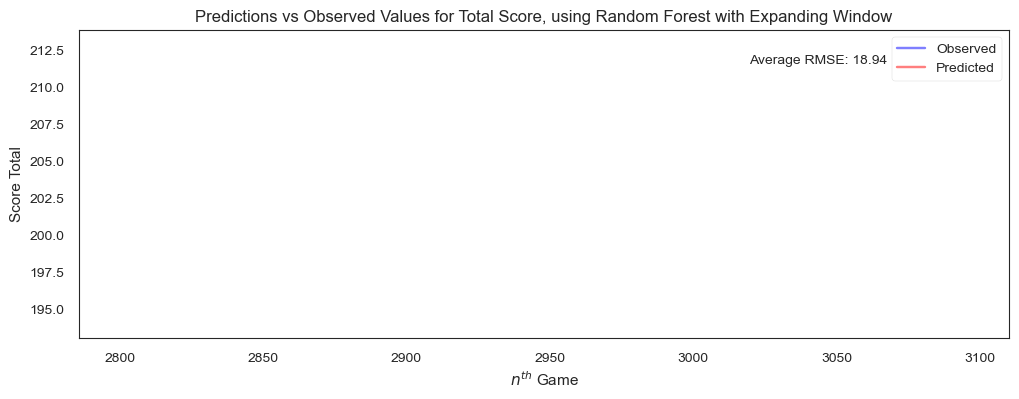

In [14]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Random Forest with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [11]:
# configuration for total points with rolling window

train_size = 500          # starting size of the training set
advancement_limit = 100   # maximum number of times the training window is advanced
test_size = 1             # leave-one-out (LOO) cross-validation
df = pts_scaled_df        # data set to use
target_col = 'TOTAL_PTS'  # target column name

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    advancement_limit=advancement_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor()
)

Total time taken: 63.89 seconds


In [12]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 21.55


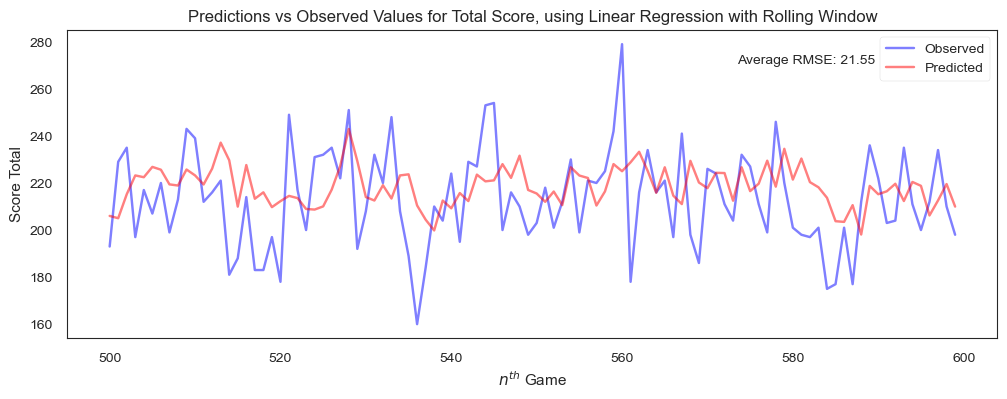

In [13]:
# check if advancement_limit is provided; if not, calculate based on the dataset size
if advancement_limit is not None:
    end_index = train_size + advancement_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = train_size + len(model_outputs) * test_size

# given the rolling nature, observed_values should start from the end of the first training set
observed_values = df[target_col][train_size:end_index]
# ensure the lengths of model_outputs and observed_values match
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="1.3.-Experiments-with-Different-Window-Sizes"></a>
## 1.3. Experiments with Different Window Sizes

[Return to top](#Baseline-Models)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [14]:
# configuration for points difference with expanding window

initial_train_size = 1476 # starting size of the training set
expansion_limit = 100     # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pm_scaled_df         # data set to use
target_col = 'PLUS_MINUS' # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor()
)

Total time taken: 232.17 seconds


In [15]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.61


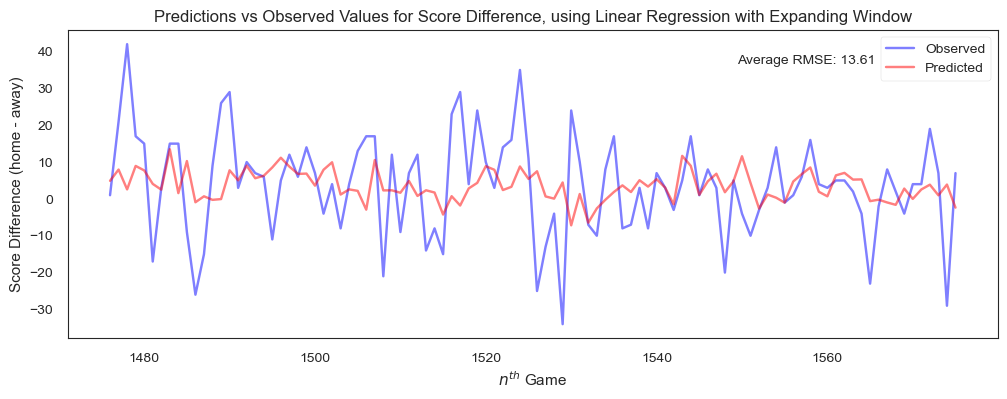

In [16]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [17]:
# configuration for points difference with rolling window

train_size = 500          # starting size of the training set
advancement_limit = 100   # maximum number of times the training window is advanced
test_size = 1             # leave-one-out (LOO) cross-validation
df = pm_scaled_df         # data set to use
target_col = 'PLUS_MINUS' # target column name

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    advancement_limit=advancement_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor()
)

Total time taken: 66.04 seconds


In [18]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.32


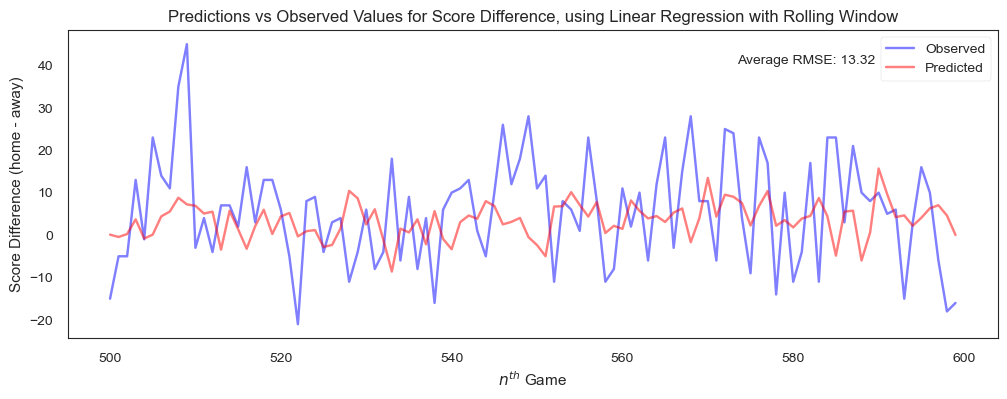

In [19]:
# check if advancement_limit is provided; if not, calculate based on the dataset size
if advancement_limit is not None:
    end_index = train_size + advancement_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = train_size + len(model_outputs) * test_size

# given the rolling nature, observed_values should start from the end of the first training set
observed_values = df[target_col][train_size:end_index]
# ensure the lengths of model_outputs and observed_values match
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [20]:
# configuration for game winner with expanding window

initial_train_size = 1476   # starting size of the training set
expansion_limit = 100       # maximum number of new training observations in expansion
test_size = 1               # leave-one-out (LOO) cross-validation
df = res_scaled_df          # data set to use
target_col = 'GAME_RESULT'  # target column name

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestClassifier(),
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 33.89 seconds


In [21]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.59
- Overall AUC: 0.59
- Average F1 Score: 0.71


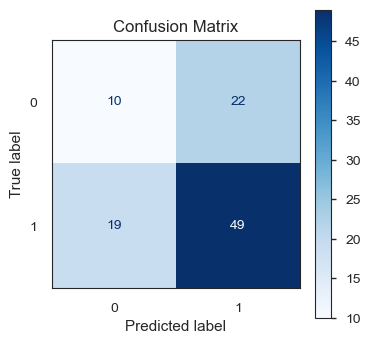

In [22]:
# calculate confusion matrix
cm = confusion_matrix(y_true, metrics['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

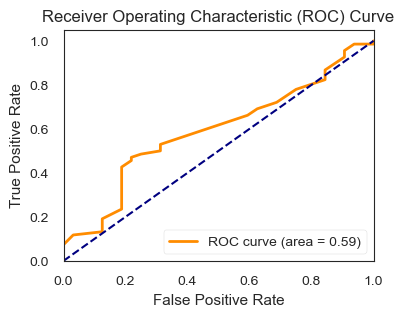

In [23]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, model_outputs)

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [24]:
# configuration for game winner with rolling window

train_size = 500            # starting size of the training set
advancement_limit = 100     # maximum number of times the training window is advanced
test_size = 1               # leave-one-out (LOO) cross-validation
df = res_scaled_df          # data set to use
target_col = 'GAME_RESULT'  # target column name

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    advancement_limit=advancement_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestClassifier(),
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 12.21 seconds


In [25]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.58
- Overall AUC: 0.50
- Average F1 Score: 0.71


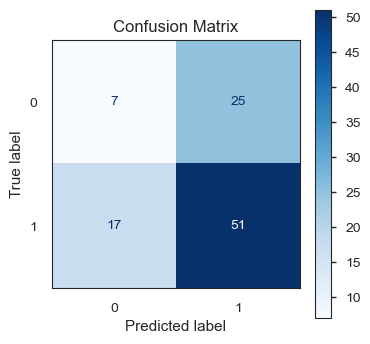

In [26]:
# calculate confusion matrix
cm = confusion_matrix(y_true, metrics['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

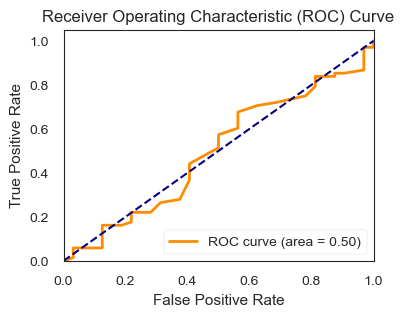

In [27]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, model_outputs)

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");